<a href="https://colab.research.google.com/github/samjurassic/datascience-demo/blob/main/workshop/DS_Skills_Lab_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Skills Lab: Exploring NYC Taxi Data with Pandas

**Goal:** Learn how to load, explore, clean, merge, and analyze real-world tabular data in Python using `pandas`.

**Learning objectives:**
- Load data from URLs into DataFrames.
- Inspect and summarize data using `head()`, `info()`, and `describe()`.
- Merge datasets and compute aggregates.
- Visualize results with `seaborn` and `matplotlib`.


Links:

- We will be using NYC taxi data. The code will automatically download the files, but you can find the files and other links here: https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page
- Read the Yellow Taxi data dictionary https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf

*Assignment:*

Use pandas to read the 2 data files into your Python notebook. Answer the following questions and upload your results here:

1. Answer the following questions:

- How many pickups happened at each NYC airport?
- How many dropoffs happened at each NYC airport?
- What is the total amount of airport fees collected at each NYC airport? (JFK and LaGuardia)
- What borough destination had the most tips?
- What were the top 10 pickup locations by number of passengers?

2. Create a data visualization of your choice

In [1]:
# Core libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Optional: improve display
pd.set_option('display.max_columns', 20)
sns.set_theme(style="whitegrid")

# Versions
print(f"pandas {pd.__version__}, seaborn {sns.__version__}")


pandas 2.2.2, seaborn 0.13.2


In [2]:
# links to data (pandas can load files from links as well as file paths)
# January 2024 data
taxi_url = (
    "https://d37ci6vzurychx.cloudfront.net/trip-data/yellow_tripdata_2024-01.parquet"
)
taxi_zone_url = "https://d37ci6vzurychx.cloudfront.net/misc/taxi_zone_lookup.csv"

# read files using appropriate pd.read_* function for each format
trips = pd.read_parquet(taxi_url, engine="pyarrow")
taxi_zones = pd.read_csv(taxi_zone_url)

In [3]:
# use .head() to display the first n rows of the dataframe
trips.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee
0,2,2024-01-01 00:57:55,2024-01-01 01:17:43,1.0,1.72,1.0,N,186,79,2,17.7,1.0,0.5,0.00,0.0,1.0,22.70,2.5,0.0
1,1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.0,1.80,1.0,N,140,236,1,10.0,3.5,0.5,3.75,0.0,1.0,18.75,2.5,0.0
2,1,2024-01-01 00:17:06,2024-01-01 00:35:01,1.0,4.70,1.0,N,236,79,1,23.3,3.5,0.5,3.00,0.0,1.0,31.30,2.5,0.0
3,1,2024-01-01 00:36:38,2024-01-01 00:44:56,1.0,1.40,1.0,N,79,211,1,10.0,3.5,0.5,2.00,0.0,1.0,17.00,2.5,0.0
4,1,2024-01-01 00:46:51,2024-01-01 00:52:57,1.0,0.80,1.0,N,211,148,1,7.9,3.5,0.5,3.20,0.0,1.0,16.10,2.5,0.0


In [4]:
taxi_zones.head()

,LocationID,Borough,Zone,service_zone
0,1,EWR,Newark Airport,EWR
1,2,Queens,Jamaica Bay,Boro Zone
2,3,Bronx,Allerton/Pelham Gardens,Boro Zone
3,4,Manhattan,Alphabet City,Yellow Zone
4,5,Staten Island,Arden Heights,Boro Zone


In [5]:
trips = (
    trips
    .assign(
        pickup_day=lambda d: d["tpep_pickup_datetime"].dt.day,
        pickup_dow=lambda d: d["tpep_pickup_datetime"].dt.day_name(),
        pickup_dow_num=lambda d: d["tpep_pickup_datetime"].dt.day_of_week
    )
)
trips[["tpep_pickup_datetime", "pickup_day", "pickup_dow", "pickup_dow_num"]].head()


,tpep_pickup_datetime,pickup_day,pickup_dow,pickup_dow_num
0,2024-01-01 00:57:55,1,Monday,0
1,2024-01-01 00:03:00,1,Monday,0
2,2024-01-01 00:17:06,1,Monday,0
3,2024-01-01 00:36:38,1,Monday,0
4,2024-01-01 00:46:51,1,Monday,0


In [6]:
trips[["tpep_pickup_datetime", "pickup_day", "pickup_dow", "pickup_dow_num"]].head()

,tpep_pickup_datetime,pickup_day,pickup_dow,pickup_dow_num
0,2024-01-01 00:57:55,1,Monday,0
1,2024-01-01 00:03:00,1,Monday,0
2,2024-01-01 00:17:06,1,Monday,0
3,2024-01-01 00:36:38,1,Monday,0
4,2024-01-01 00:46:51,1,Monday,0


### 1 - How many pickups happened at each airport?

We'll merge the taxi zone reference table with trip data to map location IDs to airport names, then group and count.


In [7]:
# # I looked up the airport codes so you don't have to
# airport_list = [132, 138] # JFK, Laguardia

# # use df.query() to use a SQL-like expression on your dataframe (@ is used to refer to a variable outside the df)
# airport_zones = taxi_zones.query("LocationID in @airport_list")


result_1 = (
    trips
    .merge(taxi_zones, left_on="PULocationID", right_on="LocationID", how="left")
    .query("Zone in ['JFK Airport', 'LaGuardia Airport', 'Newark Airport']")
    .groupby("Zone", as_index=False)
    .agg(pickup_count=('PULocationID', 'count'))
    .sort_values("pickup_count", ascending=False)
)

result_1


# result_1.columns = ["pickup_count", "passenger_count"]
# result_1.reset_index(inplace=True)

,Zone,pickup_count
0,JFK Airport,145240
1,LaGuardia Airport,89533
2,Newark Airport,295


<Axes: xlabel='Zone', ylabel='pickup_count'>

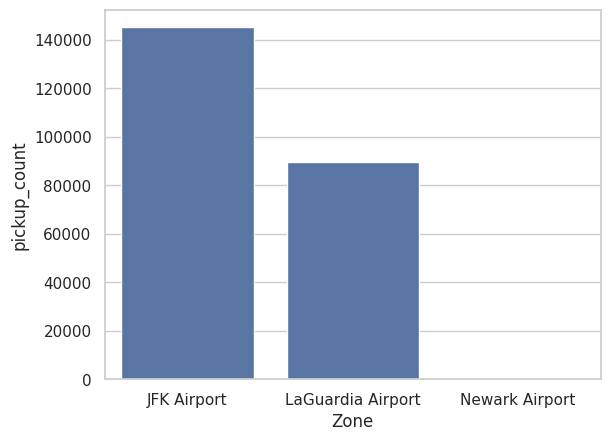

In [8]:
sns.barplot(result_1, x="Zone", y="pickup_count")

### 2 - How many dropoffs happened at each NYC airport?

In [11]:
# we are going to do the opposite merge on dropoff ID (DOLocationID)
result_2 = (
    trips
    .merge(taxi_zones, left_on="DOLocationID", right_on="LocationID", how="left")
    .query("Zone in ['JFK Airport', 'LaGuardia Airport', 'Newark Airport']")
    .groupby("Zone", as_index=False)
    .agg(dropoff_count=('DOLocationID', 'count'))
    .sort_values("dropoff_count", ascending=False)
)

result_2

,Zone,dropoff_count
1,LaGuardia Airport,31456
0,JFK Airport,31307
2,Newark Airport,7176


<Axes: xlabel='Zone', ylabel='dropoff_count'>

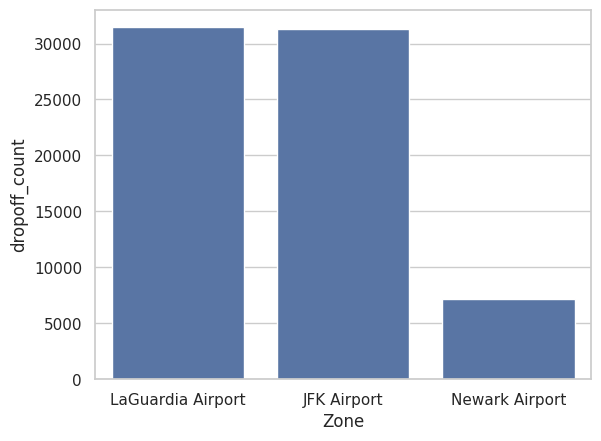

In [12]:
sns.barplot(result_2, x="Zone", y="dropoff_count")

### 3 - What is the total amount of airport fees collected at each NYC airport? (JFK and LaGuardia)

Tip, airport fee is collected by Taxi meter if picked up at an airport

In [24]:
result_3 = (
    trips
    .merge(taxi_zones, left_on="PULocationID", right_on="LocationID", how="left")
    .query("Zone in ['JFK Airport', 'LaGuardia Airport', 'Newark Airport']")
    .groupby("Zone", as_index=False)
    .agg({"Airport_fee": "sum", "PULocationID": "count"})
    .rename(columns={
        "Airport_fee": "airport_fee_sum",
        "PULocationID": "pickup_count"})
)


In [25]:
result_3

,Zone,airport_fee_sum,pickup_count
0,JFK Airport,227619.00,145240
1,LaGuardia Airport,152265.75,89533
2,Newark Airport,0.00,295


<Axes: xlabel='Zone', ylabel='airport_fee_sum'>

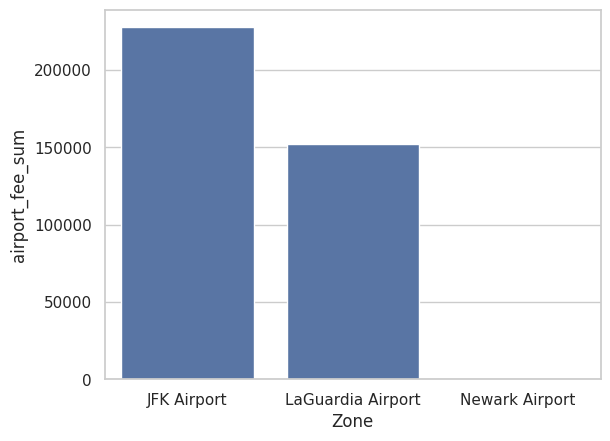

In [26]:
sns.barplot(result_3, x="Zone", y="airport_fee_sum")

### 4 - What borough destination had the most tips?

In [30]:
borough_metrics = (
    trips
    .merge(
        taxi_zones,
        left_on="DOLocationID",
        right_on="LocationID",
        how="left"
    )
    .groupby("Borough", as_index=False)
    .agg(
        total_tips=('tip_amount', 'sum'),
        dropoff_count=('DOLocationID', 'count'),
        avg_trip_distance=('trip_distance', 'mean')
    )
    .assign(
        avg_trip_distance=lambda d: d['avg_trip_distance'].round(2),
        total_tips=lambda d: d['total_tips'].round(0)
    )
    .sort_values("total_tips", ascending=False)
)


In [31]:
taxi_zones.Borough.value_counts()

,count
Borough,
Queens,69
Manhattan,69
Brooklyn,61
Bronx,43
Staten Island,20
EWR,1
Unknown,1


In [33]:
borough_metrics

,Borough,total_tips,dropoff_count,avg_trip_distance
3,Manhattan,8078592.0,2656750,2.97
4,Queens,841934.0,146987,9.24
1,Brooklyn,615015.0,107218,8.82
2,EWR,104724.0,7176,17.77
6,Unknown,56736.0,16116,2.56
0,Bronx,54539.0,17751,13.79
5,Staten Island,5809.0,659,21.08


In [35]:
borough_metrics[["Borough", "total_tips"]]

,Borough,total_tips
3,Manhattan,8078592.0
4,Queens,841934.0
1,Brooklyn,615015.0
2,EWR,104724.0
6,Unknown,56736.0
0,Bronx,54539.0
5,Staten Island,5809.0


<Axes: xlabel='Borough', ylabel='total_tips'>

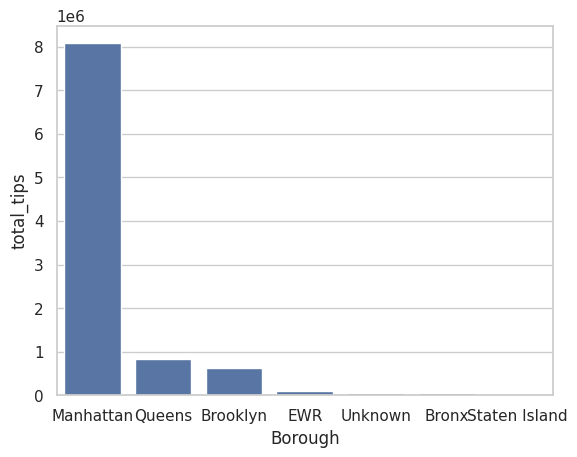

In [37]:
sns.barplot(borough_metrics, x="Borough", y="total_tips")

### 5 - What were the top 10 pickup locations by number of passengers?

In [39]:
result_5 =  (trips
    .merge(taxi_zones, left_on="PULocationID", right_on="LocationID", how="left")
    .groupby("Zone", as_index=False)
    .agg(passenger_count=("passenger_count", "sum"))
    .sort_values(by="passenger_count", ascending=False)[0:10]
)

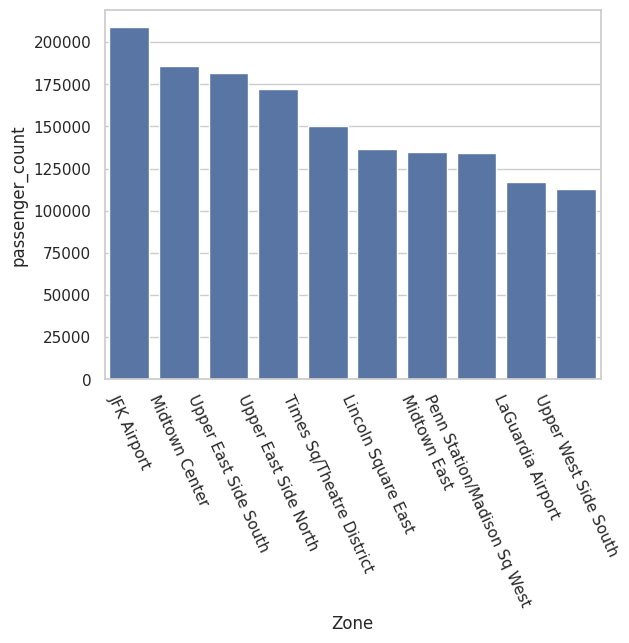

In [43]:
ax = sns.barplot(result_5, x="Zone", y="passenger_count")
# rotate ticks
plt.xticks(rotation=-65)
plt.show()

## ✅ Wrap-Up

In this lab, you practiced:
- Loading real data into pandas
- Extracting features from datetime columns
- Merging datasets and computing aggregates
- Visualizing simple summaries

**Next Steps**
- Explore averages (`.mean()`, `.median()`) for trip durations or fares.
- Try grouping by hour or day of week.
- Experiment with `pd.to_datetime()` and `.dt` accessors for other date parts.
